
# KEN4258: Computational Statistics



Task: R2 [100 points]
R2 has a problem with datasets that have a large number of predictors with respect to the number
of observations. The purpose of this graded homework assignment is to learn about this problem and
provide a solution for it. To do that, follow these steps:
1) Create a Monte Carlo simulation to illustrate the problem. [25 points]
2) Provide a mathematical proof showing that the problem really exists. [25 points]
3) Propose a solution to address the problem. [25 points]
4) Find a real dataset to illustrate the problem and your fix. [25 points]



In [45]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

### 1) Create a Monte Carlo simulation to illustrate the problem. [25 points]



The problem with the R2 metric is that, as the number of predictors increases, it cannot decrease. It can only increase of remain the same.
This is due to the fact that R2 measures portion of the variance in the dependent variable that is predictable from the independent variables.So, even if the added predictors do not offer any benefit in solving the problem, so even if the estimation of our beta is terrible, R2 will indicate a goodness of fit that is not real.


$$R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}
$$


The method used to illustrate this:


In order to show this, we have setup a Monte Carlo simulation. We have generated a dataset with 100 samples and different numbers of predictors. We have then calculated the R2 score for each number of predictors from 5 to 100. We have then plotted the R2 score as a function of the number of predictors. However, the trick is that __only 5 of the predictors have anything to do with the dependent variable__. The rest of the predictors are just noise.



In [198]:

def monte_carlo_simulation(num_samples, mean, std_dev,num_real_vars=5, MAX_NUM_VARIABLES=10):
    np.random.seed(42)  # For reproducibility
    
    
    X_full = np.random.normal(mean, std_dev, (num_samples, MAX_NUM_VARIABLES))
    coefficients = np.random.rand(num_real_vars)  # Random coefficients  (same for all trials)
    noise = np.random.normal(0, 1, num_samples)  # Random noise (same for all trials)

    r2_scores = []

    for i in range(num_real_vars, MAX_NUM_VARIABLES):
        num_variables = i
        X = X_full[:, :num_variables]
        X_subset = X[:, :num_real_vars]
        y = X_subset.dot(coefficients) + noise
              
        model = LinearRegression()
        model.fit(X, y)
        r2 = model.score(X, y)
        
        adjusted_r2 = calc_adjusted_r2(n=num_samples, p=num_variables, r2=r2)
        r2_scores.append([num_variables, r2,adjusted_r2])

        # print(f'Number of variables: {num_variables}')
        # print(f'R2 Score: {r2}')
        # print(f'Adjusted R2 Score: {adjusted_r2}')
        # print("---------------------------------------------------")

    return r2_scores

def calc_adjusted_r2(n,p,r2):
    adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))
    return adjusted_r2

results = monte_carlo_simulation(num_samples=150, mean=0, std_dev=1,num_real_vars=5, MAX_NUM_VARIABLES=100)

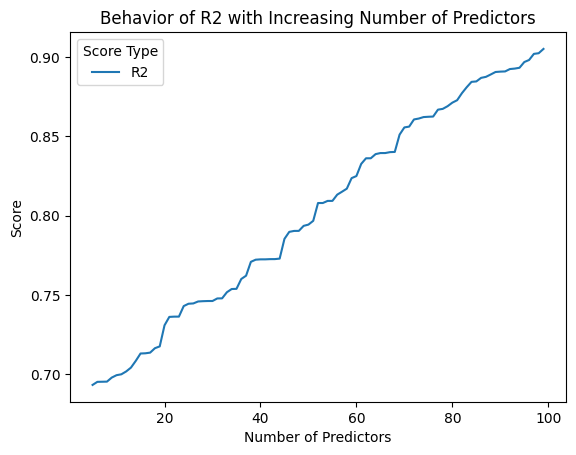

In [199]:
res_df = pd.DataFrame(results, columns=['num_variables', 'r2','adjusted_r2'])

sns.lineplot(data=res_df, x='num_variables', y='r2', label='R2')
#sns.lineplot(data=res_df, x='num_variables', y='adjusted_r2', label='Adjusted R2')

plt.title('Behavior of R2 with Increasing Number of Predictors')
plt.xlabel('Number of Predictors')
plt.ylabel('Score')

plt.legend(title='Score Type')

plt.show()

As you can observe, the  value of R2 increases as the number of predictors increases. Considering that only the first 5 predictors had actually contributed to the dependent variable, a good metric would not continue increasing after these 5. However, the R2 score will continues to increase until it indicates a score of 1.0. This score is actually possible in case the model badly overfits the data. However, in this case our model does not even overfit, it just adds more noise to our prediction. So, this is the problem with the r2 metric.






### 2) Provide a mathematical proof showing that the problem really exists. [25 points]

...


### 3) Propose a solution to address the problem. [25 points]

A solution to this problem is to use the Adjusted R2 metric. The Adjusted R2 metric is a modified version of the R2 metric that adjusts for the number of predictors in the model. The Adjusted R2 metric is calculated as follows:
$$R^2_{\text{adjusted}} = 1 - \left( \frac{(1 - R^2)(n - 1)}{n - p - 1} \right)
$$
where n is the number of observations and p is the number of predictors


As p increases, the denominator of the fractions becomes a smaller term, making the subtracted term larger, thus decreasing the Adjusted R2 score ( 1 -term). This avoids the problem of many insignificant predictors inflating the R2 score. However, if the predictors added predictors are significant, the Adjusted R2 score will also increase as the R2 does, considering the (1-R2) term will be small. So, this formula kind of weighs down the R2 by the number of it's predictors.




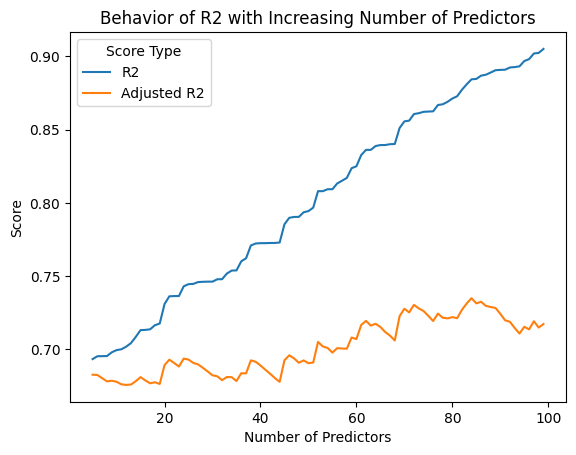

In [200]:
res_df = pd.DataFrame(results, columns=['num_variables', 'r2','adjusted_r2'])

sns.lineplot(data=res_df, x='num_variables', y='r2', label='R2')
sns.lineplot(data=res_df, x='num_variables', y='adjusted_r2', label='Adjusted R2')

plt.title('Behavior of R2 with Increasing Number of Predictors')
plt.xlabel('Number of Predictors')
plt.ylabel('Score')

plt.legend(title='Score Type')

plt.show()

As the lineplot shows, the Adjusted R2 does not increase as much as the R2 score does. It ,however, still seems to get bigger. This is due to the increase in the R2 score, and , it seems, that this form of weighting down the score with the number of predictors is not enough to actually decrease our metric. However, we can see that the Adjusted score initially decreases and then starts increases as the number of predictors becomes quite large (20+). This seems to indicate that some of the random noise accidentally contributed to a better result in this toy example. Still, it is obvious that it is not worth adding 15 more predictors to increase the Adjusted R2 score very slightly. So, indeed, this metric is more practical in the case of evaluating models with many predictors.


In [203]:
# smoothed plot

# window_size = 5  
# 
# res_df['r2_smoothed'] = res_df['r2'].rolling(window=window_size).mean()
# res_df['adjusted_r2_smoothed'] = res_df['adjusted_r2'].rolling(window=window_size).mean()
# 
# # Plot the smoothed data
# sns.lineplot(data=res_df, x='num_variables', y='r2_smoothed', label='R2 Smoothed')
# sns.lineplot(data=res_df, x='num_variables', y='adjusted_r2_smoothed', label='Adjusted R2 Smoothed')
# 
# 
# plt.title('Smoothed - Behavior of R2 with Increasing Number of Predictors')
# plt.xlabel('Number of Predictors')
# plt.ylabel('Score')
# 
# plt.legend(title='Score Type')



### 4) Find a real dataset to illustrate the problem and your fix. [25 points]

...